# Using KD-tree to query wikidata

In [1]:
import glob
import pandas as pd
import numpy as np
import os
import pandas as pd
import pyproj
from scipy import spatial

## Read Wikidata and create KD-tree

In [2]:
# Read Wikidata, distributed over several CSV files
df_wiki = pd.concat(map(pd.read_csv, 
                   glob.glob(os.path.join('', "/home/mcollardanuy/PlaceLinking/wikidata/extracted/*csv"))))
df_wiki.head()

,Unnamed: 0,wikidata_id,english_label,instance_of,description_set,alias_dict,nativelabel,population_dict,area,hcounties,...,vchIDs,vob_placeIDs,vob_unitIDs,epns,os_grid_ref,connectswith,street_address,adjacent_stations,ukrailcode,connectline
0,0,Q34811468,Atten Park,['Q22698'],{'park in the United States of America'},{'en': ['Atten Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Q34811469,Taboren,['Q8502'],{'mountain in Norway'},{'en': ['Taboren']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Q34811478,Atterbury State Fish and Wildlife Area,['Q22698'],{'park in the United States of America'},{'en': ['Atterbury State Fish and Wildlife Are...,NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Q34811496,Alvin Wirtz Park,['Q22698'],{'park in the United States of America'},{'en': ['Alvin Wirtz Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Q34811534,Atwood Park,['Q22698'],{'park in the United States of America'},{'en': ['Atwood Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
df_wiki.head()

,Unnamed: 0,wikidata_id,english_label,instance_of,description_set,alias_dict,nativelabel,population_dict,area,hcounties,...,vchIDs,vob_placeIDs,vob_unitIDs,epns,os_grid_ref,connectswith,street_address,adjacent_stations,ukrailcode,connectline
0,0,Q34811468,Atten Park,['Q22698'],{'park in the United States of America'},{'en': ['Atten Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Q34811469,Taboren,['Q8502'],{'mountain in Norway'},{'en': ['Taboren']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,Q34811478,Atterbury State Fish and Wildlife Area,['Q22698'],{'park in the United States of America'},{'en': ['Atterbury State Fish and Wildlife Are...,NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Q34811496,Alvin Wirtz Park,['Q22698'],{'park in the United States of America'},{'en': ['Alvin Wirtz Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Q34811534,Atwood Park,['Q22698'],{'park in the United States of America'},{'en': ['Atwood Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print(len(df_wiki))

8094093


In [5]:
# transform lat/lon ---> x,y,z
# x,y,z will be used to create the KD-tree
ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
x_wiki, y_wiki, z_wiki = pyproj.transform(lla, ecef,
                                          df_wiki["longitude"].to_numpy(),
                                          df_wiki["latitude"].to_numpy(),
                                          np.zeros(len(df_wiki["latitude"])),
                                          radians=False)

/data/anaconda/envs/py37deezy/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  if __name__ == '__main__':


In [6]:
# add x, y, z to df
df_wiki["x"] = x_wiki
df_wiki["y"] = y_wiki
df_wiki["z"] = z_wiki
df_wiki.head()

,Unnamed: 0,wikidata_id,english_label,instance_of,description_set,alias_dict,nativelabel,population_dict,area,hcounties,...,epns,os_grid_ref,connectswith,street_address,adjacent_stations,ukrailcode,connectline,x,y,z
0,0,Q34811468,Atten Park,['Q22698'],{'park in the United States of America'},{'en': ['Atten Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.541576e+05,-4.756271e+06,4.232495e+06
1,1,Q34811469,Taboren,['Q8502'],{'mountain in Norway'},{'en': ['Taboren']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.974213e+06,8.109197e+05,5.990299e+06
2,2,Q34811478,Atterbury State Fish and Wildlife Area,['Q22698'],{'park in the United States of America'},{'en': ['Atterbury State Fish and Wildlife Are...,NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.385981e+05,-4.924514e+06,4.025658e+06
3,3,Q34811496,Alvin Wirtz Park,['Q22698'],{'park in the United States of America'},{'en': ['Alvin Wirtz Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.969652e+05,-5.439365e+06,3.223162e+06
4,4,Q34811534,Atwood Park,['Q22698'],{'park in the United States of America'},{'en': ['Atwood Park']},NaN,{},NaN,[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.614069e+04,-4.751526e+06,4.239891e+06


In [7]:
# Create wiki_kdtree
wiki_kdtree = spatial.cKDTree(df_wiki[["x", "y", "z"]].to_numpy())

## NOT NEEDED, SKIP, Add a dummy row to `df_wiki`

We add a row to `df_wiki` for cases where kd-tree cannot find a candidate. This way, we can run most of the codes in a vectorized way (and not using explicit for-loops).

In [8]:
# dummy_index = -999
# if not dummy_index in df_wiki.index:
#     df_wiki.loc[dummy_index] = df_wiki.iloc[0]
#     df_wiki.loc[dummy_index, "english_label"] = "kdtree_not_found_candidate"
# else:
#     print(f"Dummy index: {dummy_index} already exists in the dataframe.")

In [9]:
# df_wiki

## Read GB1900

In [10]:
# Read GB1900
with open("/resources/gb1900/gb1900_gazetteer_complete_july_2018.csv", encoding='UTF-16') as f:
    df_gb1900 = pd.read_csv(f)

/data/anaconda/envs/py37deezy/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# transform lat/lon ---> x,y,z
x_gb, y_gb, z_gb = pyproj.transform(lla, ecef,
                                    df_gb1900["longitude"].to_numpy(),
                                    df_gb1900["latitude"].to_numpy(),
                                    np.zeros(len(df_gb1900["latitude"])),
                                    radians=False)

/data/anaconda/envs/py37deezy/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  


## Find neighbours

Here, our query points are from GB1900: x_gb, y_gb and z_gb, we use wiki_kdtree to find the closest points to GB1900 labels.

In [12]:
# Define threshold (static)
num_neighbors = 10
# distance in m
distance_upper_bound = 1000

all_dists, all_indxs = wiki_kdtree.query(np.array([x_gb, y_gb, z_gb]).T,
                                         k=num_neighbors,
                                         distance_upper_bound=distance_upper_bound)

In [13]:
all_indxs

array([[4323062, 3623370, 3360538, ..., 2266493, 5295829, 6661991],
       [ 346998, 2561191,  436695, ..., 5299495, 7038452, 5379855],
       [2561191, 7463327,  346998, ..., 5320821,  524029,  436695],
       ...,
       [1359730, 3062457, 6778293, ..., 5317385, 5317592, 3380280],
       [3946269, 5497323, 6650225, ..., 5317592, 4325756, 6366686],
       [5921107, 4358245, 5295828, ..., 8094093, 8094093, 8094093]])

## Calculate string similarity between one query and all candidates and store the results

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
import pickle

def create_candidate_list(ind1, ind2, df_gb1900, df_wiki, 
                          all_indxs, all_dists, 
                          ngram_range=(1, 3), save_candidate=False,
                          save_par_dir="results"):
    """
    ind1, ind2: GB1900 indices, if ind2 < 0, use the whole gb1900 dataframe
    all_indxs and all_dists should be computed in the previous cell
        ngram_range: to be used in TF-IDF
    
    OUTPUT:
    [
        [
            [query_str_1, query_id_1], 
            [candidate_name_1, candidate_string_score_1, distance_1, wikidata_id_1],
            [candidate_name_2, candidate_string_score_2, distance_2, wikidata_id_2],
            ...
        ],
        
        [
            [query_str_2, query_id_2], 
            ...
        ],
        ...
    ]
    """
    
    if ind2 < 0:
        ind2 = len(df_gb1900)
    
    assert ind1 <= ind2, "ind1 should be <= ind2"
    ind2 = min(ind2, len(df_gb1900))
    
    candidate_list = []
    for i in tqdm(range(ind1, ind2)):
        
        candidate_list.append([[df_gb1900.iloc[i]["final_text"], i]])
        
        # Print progress every 1000 steps
        # if (i - ind1) % 1000 == 0:
        #      print((i - ind1) / (ind2 - ind1) * 100)
            
        row_index = all_indxs[i]
        row_dist = all_dists[i]

        # Filter out those candidates with distance of inf
        row_index_filt = row_index[row_dist != np.inf]
        row_dist_filt = row_dist[row_dist != np.inf]
        df_wiki_filt = df_wiki.iloc[row_index_filt]
        
        for j in range(len(df_wiki_filt)):
            # alt_names include english_label and alias_dict
            alt_names = set()
            alt_names.add(str(df_wiki_filt.iloc[j]["english_label"]))
            
            row_alias_dict = eval(df_wiki_filt.iloc[j]["alias_dict"]).get("en", False)
            
            if row_alias_dict:
                alt_names.update(row_alias_dict)    

            # Calculate string similarity between final_text and alt_names
            str_sim = [df_gb1900.iloc[i]["final_text"]]
            str_sim.extend(alt_names)
            
            tfidf = TfidfVectorizer(analyzer="char_wb", ngram_range=ngram_range).fit_transform(str_sim)
            pairwise_similarity = tfidf * tfidf.T
            
            pairwise_arr = pairwise_similarity.toarray()
            # only the first row is needed as we are comparing "final_text" with the rest
            pairwise_arr_first_row = pairwise_arr[0][1:]

            candidates_name = np.array(str_sim[1:]).tolist()
            candidates_score = pairwise_arr_first_row.tolist()
            
            for k in range(len(candidates_name)):
                candidate_list[-1].append([candidates_name[k], 
                                           candidates_score[k], 
                                           all_dists[i][j], 
                                           df_wiki_filt.iloc[j]["wikidata_id"]])
        
    if save_candidate:
        if not os.path.isdir(save_par_dir):
            os.makedirs(save_par_dir)
        with open(os.path.join(save_par_dir, f"./candidate_{ind1}_{ind2}"), 'wb') as f:
            pickle.dump(candidate_list, f)
    else:
        return candidate_list

## Test

In [15]:
# 1. Find the GB1900 ID associated to a query
query = "King's Cross Sta."
df_query = df_gb1900[df_gb1900['final_text'].str.contains(query, case=False)]
df_query.head()

,pin_id,final_text,nation,local_authority,parish,osgb_east,osgb_north,latitude,longitude,notes
39869,57eebf702c66dca322009566,King's Cross Sta.,England,Camden,Camden (Un-parished),530210.590032,182959.512834,51.530538,-0.124229,NaN


In [16]:
# Do we have the query in wikidata
df_wiki[df_wiki['english_label'].str.contains(query, case=False, na=False)][["english_label", "latitude", "longitude"]]

,english_label,latitude,longitude


In [17]:
# 2. use the id
query_id = 39869
found_candidates = create_candidate_list(query_id, query_id + 10, 
                                         df_gb1900, df_wiki, 
                                         all_indxs, all_dists,
                                         ngram_range=(1, 3)
                                        )

100%|██████████| 10/10 [00:00<00:00, 45.73it/s]


In [18]:
# Print results for one set of candidates

print(f'{"Candidate":>30}\t{"Sim. score"}\t{"distance (m)"}\t{"wikidata_id"}')
print(80*"=")
for i in found_candidates[0][1:]:
    print(f"{i[0][:30]:>30}\t{i[1]:.4f}\t\t{i[2]:.2f}\t\t{i[3]}")

                     Candidate	Sim. score	distance (m)	wikidata_id
             King's Cross fire	0.7763		23.69		Q58395
           Large Spindle Piece	0.3123		37.36		Q19759086
King's Cross St. Pancras Under	0.6912		38.70		Q826120
King's Cross & St. Pancras tub	0.7398		38.70		Q826120
King's Cross St. Pancras stati	0.7964		38.70		Q826120
King's Cross St. Pancras tube 	0.7575		38.70		Q826120
King's Cross for St. Pancras t	0.7206		38.70		Q826120
King's Cross & St. Pancras Und	0.6871		38.70		Q826120
King's Cross Underground stati	0.6318		38.70		Q826120
Kings Cross St. Pancras Underg	0.6499		38.70		Q826120
King's Cross for St. Pancras U	0.6703		38.70		Q826120
Kings Cross St. Pancras tube s	0.7086		38.70		Q826120
     King's Cross tube station	0.7427		38.70		Q826120
             Drinking fountain	0.3438		47.37		Q96875136
                   Kings Cross	0.7313		51.09		Q2153507
                  King's Cross	0.8358		51.09		Q2153507
          Great Northern Hotel	0.2977		66.42		Q26407124
Great No

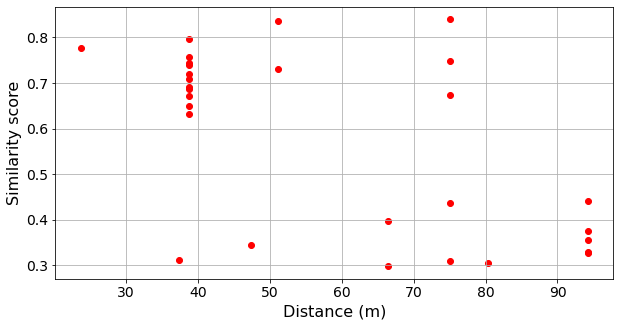

In [19]:
# Simple plot, similarity score vs distance
import matplotlib.pyplot as plt

found_candidates_arr = np.array(found_candidates[0][1:])

plt.figure(figsize=(10, 5))
plt.scatter(found_candidates_arr[:, 2].astype(np.float), 
            found_candidates_arr[:, 1].astype(np.float),
            color='r')
plt.grid()
plt.xlabel("Distance (m)", size=16)
plt.ylabel("Similarity score", size=16)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

## Run in parallel

In [20]:
import multiprocessing
import time

def check_par_jobs(jobs, sleep_time=1):
    """
    check if all the parallel jobs are finished
    :param jobs:
    :param sleep_time:
    :return:
    """
    pp_flag = True
    while pp_flag:
        for proc in jobs:
            if proc.is_alive():
                time.sleep(sleep_time)
                pp_flag = True
                break
            else:
                pp_flag = False
    if not pp_flag:
        print('\n\n================================')
        print('All %s processes are finished...' % len(jobs))
        print('================================')

def run_parallel(start, end, target_func, process_np=8, **kwds):
    """
    Run target_func in parallel
    process_np: number of CPUs
    start, end are the indices (e.g., 0 and len(df_gb1900))
    """

    if end < process_np:
        req_proc = end
    else:
        req_proc = process_np

    step = (end - start) / req_proc + 1
    step = int(step)

    jobs = []
    for index in range(req_proc):
        starti = start + index * step
        endi = min(start + (index + 1) * step, end)
        if starti >= endi:
            break
        p = multiprocessing.Process(target=target_func,
                                    args=(starti, endi,
                                          kwds["df_gb1900"], 
                                          kwds["df_wiki"], 
                                          kwds["all_indxs"], 
                                          kwds["all_dists"], 
                                          kwds["ngram_range"], 
                                          kwds["save_candidate"]))
        jobs.append(p)
    for i in range(len(jobs)):
        jobs[i].start()
        
    check_par_jobs(jobs)

In [21]:
run_parallel(0, 500000, 
             create_candidate_list, 
             process_np=16, 
             df_gb1900=df_gb1900, 
             df_wiki=df_wiki, 
             all_indxs=all_indxs, 
             all_dists=all_dists,
             ngram_range=(1, 3),
             save_candidate=True,
             save_par_dir="results")

100%|██████████| 31251/31251 [16:08<00:00, 32.27it/s]




All 16 processes are finished...


# --- PLAYGROUND

In [ ]:
# # By having the indices (all_indxs), extract english_label
# collect_candidates = None
# for nqueries in range(all_indxs.shape[1]):
#     print(nqueries, end=", ")
#     if isinstance(collect_candidates, type(None)):
#         collect_candidates = df_wiki.iloc[all_indxs[:, nqueries]][["english_label"]].to_numpy()
#     else:
#         collect_candidates = np.hstack([collect_candidates, 
#                                         df_wiki.iloc[all_indxs[:, nqueries]][["english_label"]].to_numpy()])